In [76]:
from tensorflow import keras
from keras.utils import timeseries_dataset_from_array
help(timeseries_dataset_from_array)

Help on function timeseries_dataset_from_array in module keras.src.utils.timeseries_dataset_utils:

timeseries_dataset_from_array(data, targets, sequence_length, sequence_stride=1, sampling_rate=1, batch_size=128, shuffle=False, seed=None, start_index=None, end_index=None)
    Creates a dataset of sliding windows over a timeseries provided as array.
    
    This function takes in a sequence of data-points gathered at
    equal intervals, along with time series parameters such as
    length of the sequences/windows, spacing between two sequence/windows, etc.,
    to produce batches of timeseries inputs and targets.
    
    Args:
        data: Numpy array or eager tensor
            containing consecutive data points (timesteps).
            Axis 0 is expected to be the time dimension.
        targets: Targets corresponding to timesteps in `data`.
            `targets[i]` should be the target
            corresponding to the window that starts at index `i`
            (see example 2 be

In [77]:
import pandas as pd
import numpy as np

hurricane_df = pd.read_csv("../data/processed/atlantic_storms_cleaned.csv")
hurricane_df.head(5)
hurricane_df['Storm_category'].dropna()

0                 Category 1
1                 Category 1
2                 Category 1
3                 Category 1
4                 Category 1
                ...         
55225         Tropical Storm
55226         Tropical Storm
55227         Tropical Storm
55228    Tropical Depression
55229    Tropical Depression
Name: Storm_category, Length: 55173, dtype: object

In [78]:
hurricane_df

,Storm_id,Storm_name,Timestamp(UTC),Storm_duration_days,Storm_category,Type_of_storm,Month,Year,Wind_mph,Wind_knots,Pressure_mb,Lat,Lon
0,AL011851,UNNAMED,1851-06-25 00:00:00,3,Category 1,HU,6,1851,92.0624,80,-999,28.0,-94.8
1,AL011851,UNNAMED,1851-06-25 06:00:00,3,Category 1,HU,6,1851,92.0624,80,-999,28.0,-95.4
2,AL011851,UNNAMED,1851-06-25 12:00:00,3,Category 1,HU,6,1851,92.0624,80,-999,28.0,-96.0
3,AL011851,UNNAMED,1851-06-25 18:00:00,3,Category 1,HU,6,1851,92.0624,80,-999,28.1,-96.5
4,AL011851,UNNAMED,1851-06-25 21:00:00,3,Category 1,HU,6,1851,92.0624,80,-999,28.2,-96.8
...,...,...,...,...,...,...,...,...,...,...,...,...,...
55225,AL192024,SARA,2024-11-17 06:00:00,4,Tropical Storm,TS,11,2024,40.2773,35,1001,16.5,-87.5
55226,AL192024,SARA,2024-11-17 12:00:00,4,Tropical Storm,TS,11,2024,40.2773,35,1001,16.8,-87.9
55227,AL192024,SARA,2024-11-17 14:00:00,4,Tropical Storm,TS,11,2024,40.2773,35,1001,17.0,-88.3
55228,AL192024,SARA,2024-11-17 18:00:00,4,Tropical Depression,TD,11,2024,34.5234,30,1003,17.4,-89.1


In [79]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

hurricane_df_train = hurricane_df.drop(['Storm_id','Storm_name' ,'Timestamp(UTC)'], axis=1)

hurricane_df_train = pd.get_dummies(hurricane_df_train, columns= ['Storm_category', 'Type_of_storm'])

storm_cat = hurricane_df_train.columns[hurricane_df_train.columns.str.startswith('Storm_category')].tolist()
storm_type = hurricane_df_train.columns[hurricane_df_train.columns.str.startswith('Type_of_storm')].tolist()

feature_cols = ['Month', 'Year', 'Lat', 'Lon']
target_cols = ['Wind_mph', 'Pressure_mb']

X = hurricane_df_train[feature_cols + storm_type]
y = hurricane_df_train[target_cols]

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=42)

scaler = StandardScaler()
X_train[feature_cols] = scaler.fit_transform(X_train[feature_cols])
X_test[feature_cols] = scaler.transform(X_test[feature_cols])

scaler_y = StandardScaler()
y_train_scaled = scaler_y.fit_transform(y_train)
y_test_scaled = scaler_y.transform(y_test)


In [89]:
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam

model = Sequential()
model.add(Dense(64, activation='relu', input_shape=(X_train.shape[1],)))
model.add(Dense(32, activation='relu'))
model.add(Dense(16, activation='relu'))
model.add(Dense(y_train.shape[1], activation='linear'))
optimizer = Adam(learning_rate=1e-4)
model.compile(optimizer=optimizer, loss='mse', metrics=['mse'])

/opt/anaconda3/envs/ml-env/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
from keras.callbacks import EarlyStopping
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=10,               # stop if no improvement for 10 epochs
    restore_best_weights=True  # revert to best model
)

history = model.fit(X_train, y_train_scaled, 
                    validation_split=0.2,  # optional, hold out 20% of train for val
                    epochs=20,            # adjust depending on convergence
                    batch_size=32,
                    verbose=1)


Epoch 1/20
1105/1105 ━━━━━━━━━━━━━━━━━━━━ 16s 14ms/step - loss: 0.3137 - mse: 0.3137 - val_loss: 0.3148 - val_mse: 0.3148
Epoch 2/20
1105/1105 ━━━━━━━━━━━━━━━━━━━━ 15s 14ms/step - loss: 0.3138 - mse: 0.3138 - val_loss: 0.3150 - val_mse: 0.3150
Epoch 3/20
1105/1105 ━━━━━━━━━━━━━━━━━━━━ 15s 14ms/step - loss: 0.3140 - mse: 0.3140 - val_loss: 0.3148 - val_mse: 0.3148
Epoch 4/20
1105/1105 ━━━━━━━━━━━━━━━━━━━━ 16s 14ms/step - loss: 0.3143 - mse: 0.3143 - val_loss: 0.3159 - val_mse: 0.3159
Epoch 5/20
1105/1105 ━━━━━━━━━━━━━━━━━━━━ 16s 14ms/step - loss: 0.3149 - mse: 0.3149 - val_loss: 0.3177 - val_mse: 0.3177
Epoch 6/20
1105/1105 ━━━━━━━━━━━━━━━━━━━━ 16s 14ms/step - loss: 0.3160 - mse: 0.3160 - val_loss: 0.3177 - val_mse: 0.3177
Epoch 7/20
1105/1105 ━━━━━━━━━━━━━━━━━━━━ 16s 14ms/step - loss: 0.3177 - mse: 0.3177 - val_loss: 0.3236 - val_mse: 0.3236
Epoch 8/20
1105/1105 ━━━━━━━━━━━━━━━━━━━━ 16s 14ms/step - loss: 0.3220 - mse: 0.3220 - val_loss: 0.3230 - val_mse: 0.3230
Epoch 9/20
1105/1105 ━━━

In [85]:
model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_15 (Dense)                │ (None, 64)             │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 2)              │            34 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 10,616 (41.47 KB)

 Trainable params: 3,538 (13.82 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 7,078 (27.65 KB)

In [86]:
loss, mae = model.evaluate(X_test, y_test_scaled)
print(f"Test Loss: {loss}")
print(f"Test MAE: {mae}")

346/346 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.3286 - mse: 0.3286
Test Loss: 0.32857346534729004
Test MAE: 0.32857346534729004


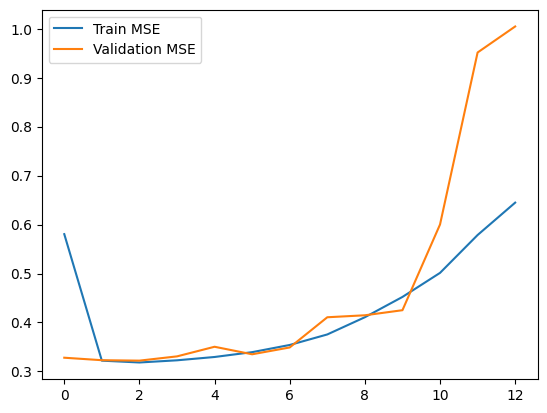

In [84]:
import matplotlib.pyplot as plt

plt.plot(history.history['mse'], label='Train MSE')
plt.plot(history.history['val_mse'], label='Validation MSE')
plt.legend()